In [48]:
import uproot
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc


file_prompt = uproot.open("Prompt_DstarToD0Pi.root")
tree_prompt = file_prompt["treeMLDstar"]

print(file_prompt.keys())
tree_prompt.keys()

['treeMLDstar;1']


['fCandidateSelFlag',
 'fChi2PCAD0',
 'fCosThetaStarD0',
 'fCpaD0',
 'fCpaXYD0',
 'fDecayLengthD0',
 'fDecayLengthNormalisedD0',
 'fDecayLengthXYD0',
 'fDecayLengthXYNormalisedD0',
 'fEta',
 'fEtaD0',
 'fFlagMcMatchRec',
 'fImpParamSoftPi',
 'fImpactParameter0',
 'fImpactParameter1',
 'fImpactParameterNormalised0',
 'fImpactParameterNormalised1',
 'fImpactParameterNormalisedSoftPi',
 'fImpactParameterProductD0',
 'fM',
 'fMD0',
 'fMaxNormalisedDeltaIPD0',
 'fNSigTofKa0',
 'fNSigTofKa1',
 'fNSigTofKaSoftPi',
 'fNSigTofPi0',
 'fNSigTofPi1',
 'fNSigTofPiSoftPi',
 'fNSigTpcKa0',
 'fNSigTpcKa1',
 'fNSigTpcKaSoftPi',
 'fNSigTpcPi0',
 'fNSigTpcPi1',
 'fNSigTpcPiSoftPi',
 'fNSigTpcTofKa0',
 'fNSigTpcTofKa1',
 'fNSigTpcTofKaSoftPi',
 'fNSigTpcTofPi0',
 'fNSigTpcTofPi1',
 'fNSigTpcTofPiSoftPi',
 'fPhi',
 'fPhiD0',
 'fPt',
 'fPtBhadMother',
 'fPtD0',
 'fPtProng0',
 'fPtProng1',
 'fPtSoftPi',
 'fY',
 'fYD0',
 'fInvDeltaMass']

In [49]:
pip install uproot

In [50]:
print("GPU available:", torch.cuda.is_available())

GPU available: False


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [52]:
file_prompt = uproot.open("Prompt_DstarToD0Pi.root")
file_nonprompt = uproot.open("Nonprompt_DstarToD0Pi.root")
file_bkg = uproot.open("Bkg_DstarToD0Pi.root")

tree_prompt = file_prompt["treeMLDstar"]
tree_nonprompt = file_nonprompt["treeMLDstar"]
tree_bkg = file_bkg["treeMLDstar"]


branches_all = [
    "fPtD0",

    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0",

    "fNSigTpcPi0",
    "fNSigTpcKa0",
    "fNSigTofPi0",
    "fNSigTofKa0",

    "fNSigTpcPi1",
    "fNSigTpcKa1",
    "fNSigTofPi1",
    "fNSigTofKa1"
]


branches = [

    "fCpaD0",
    "fCpaXYD0",
    "fDecayLengthXYD0",
    "fImpactParameterProductD0",
    "fImpParamSoftPi",
    "fMaxNormalisedDeltaIPD0",

    "fNSigTpcPi0",
    "fNSigTpcKa0",
    "fNSigTofPi0",
    "fNSigTofKa0",

    "fNSigTpcPi1",
    "fNSigTpcKa1",
    "fNSigTofPi1",
    "fNSigTofKa1"
]


arr_prompt = tree_prompt.arrays(branches_all, library="np")
arr_nonprompt = tree_nonprompt.arrays(branches_all, library="np")
arr_bkg = tree_bkg.arrays(branches_all, library="np")

pt_min = 3.67
pt_max = 5.67

mask_prompt = (arr_prompt["fPtD0"] > pt_min) & (arr_prompt["fPtD0"] < pt_max)
mask_nonprompt = (arr_nonprompt["fPtD0"] > pt_min) & (arr_nonprompt["fPtD0"] < pt_max)
mask_bkg = (arr_bkg["fPtD0"] > pt_min) & (arr_bkg["fPtD0"] < pt_max)

for b in branches:
    arr_prompt[b] = arr_prompt[b][mask_prompt]
    arr_nonprompt[b] = arr_nonprompt[b][mask_nonprompt]
    arr_bkg[b] = arr_bkg[b][mask_bkg]


def build_X(arr):
    return np.column_stack([arr[b] for b in branches])

X_prompt = build_X(arr_prompt)
X_nonprompt = build_X(arr_nonprompt)
X_bkg = build_X(arr_bkg)


y_prompt = np.zeros(len(X_prompt))
y_nonprompt = np.ones(len(X_nonprompt))
y_bkg = 2 * np.ones(len(X_bkg))


X = np.vstack((X_prompt, X_nonprompt, X_bkg))
y = np.concatenate((y_prompt, y_nonprompt, y_bkg))


print("X shape:", X.shape)
print("y shape:", y.shape)
print("First 10 labels:", y[:10])

X shape: (1040228, 14)
y shape: (1040228,)
First 10 labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [53]:
X = np.nan_to_num(X, nan=0.0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    shuffle=True
)


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


print("Mean of first feature (train):", X_train_scaled[:,0].mean())
print("Std of first feature (train):", X_train_scaled[:,0].std())

Mean of first feature (train): -2.0169475e-09
Std of first feature (train): 1.0


In [54]:
class D0Classifier(nn.Module):
    def __init__(self):
        super(D0Classifier, self).__init__()

        self.fc1 = nn.Linear(14, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 3)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)   # logits
        return x

In [55]:
model = D0Classifier().to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.005
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=20,
    gamma=0.5
)

In [56]:
print("NaNs in X:", np.isnan(X).sum())
print("Infs in X:", np.isinf(X).sum())

NaNs in X: 0
Infs in X: 0


Epoch 5/30, Loss = 0.4277
Epoch 10/30, Loss = 0.4127
Epoch 15/30, Loss = 0.4060
Epoch 20/30, Loss = 0.4038
Epoch 25/30, Loss = 0.3987
Epoch 30/30, Loss = 0.3972


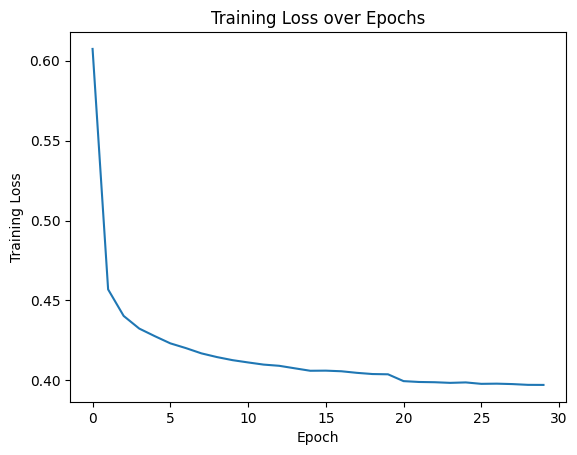

In [57]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

from torch.utils.data import TensorDataset, DataLoader

batch_size = 4096

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

n_epochs = 30

train_losses = []

for epoch in range(n_epochs):

    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss = {avg_loss:.4f}")

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

In [58]:
print(torch.version.cuda)
print(torch.cuda.is_available())

None
False


Test Accuracy: 0.8414421169677219
Confusion Matrix:
 [[ 55960   6905   9768]
 [ 17016  64963   4636]
 [  7490   3666 141665]]


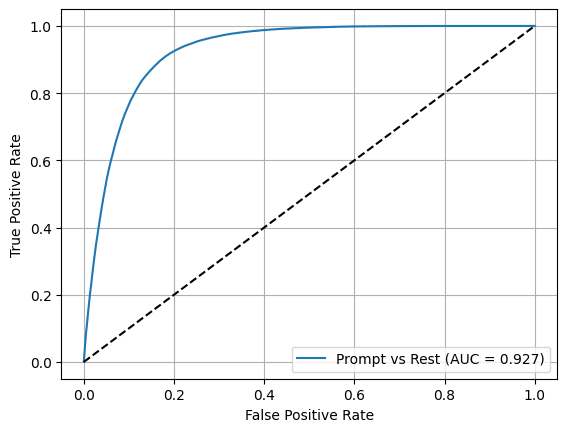

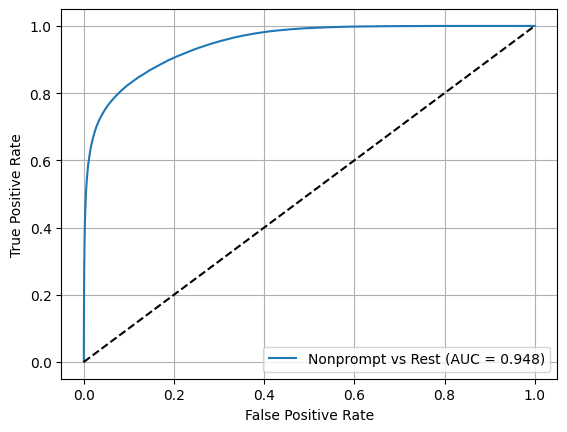

In [59]:
model.eval()

with torch.no_grad():
    outputs_test = model(X_test_t)
    probs_test = torch.softmax(outputs_test, dim=1)
    preds_test = torch.argmax(probs_test, dim=1).cpu().numpy()

acc = accuracy_score(y_test, preds_test)
print("Test Accuracy:", acc)

cm = confusion_matrix(y_test, preds_test)
print("Confusion Matrix:\n", cm)

y_true_prompt = (y_test == 0).astype(int)
scores_prompt = probs_test[:,0].cpu().numpy()

fpr_p, tpr_p, _ = roc_curve(y_true_prompt, scores_prompt)
auc_p = auc(fpr_p, tpr_p)

plt.figure()
plt.plot(fpr_p, tpr_p, label=f"Prompt vs Rest (AUC = {auc_p:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

y_true_np = (y_test == 1).astype(int)
scores_np = probs_test[:,1].cpu().numpy()

fpr_np, tpr_np, _ = roc_curve(y_true_np, scores_np)
auc_np = auc(fpr_np, tpr_np)

plt.figure()
plt.plot(fpr_np, tpr_np, label=f"Nonprompt vs Rest (AUC = {auc_np:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

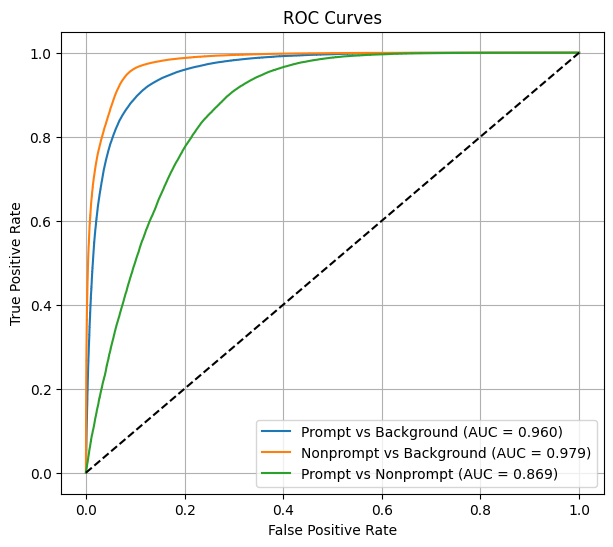

In [60]:
probs_np = probs_test.cpu().numpy()

mask_pb = (y_test == 0) | (y_test == 2)
y_pb = (y_test[mask_pb] == 0).astype(int)
scores_pb = probs_np[mask_pb, 0]

fpr_pb, tpr_pb, _ = roc_curve(y_pb, scores_pb)
auc_pb = auc(fpr_pb, tpr_pb)


mask_npb = (y_test == 1) | (y_test == 2)
y_npb = (y_test[mask_npb] == 1).astype(int)
scores_npb = probs_np[mask_npb, 1]

fpr_npb, tpr_npb, _ = roc_curve(y_npb, scores_npb)
auc_npb = auc(fpr_npb, tpr_npb)


mask_pnp = (y_test == 0) | (y_test == 1)
y_pnp = (y_test[mask_pnp] == 0).astype(int)
scores_pnp = probs_np[mask_pnp, 0]

fpr_pnp, tpr_pnp, _ = roc_curve(y_pnp, scores_pnp)
auc_pnp = auc(fpr_pnp, tpr_pnp)

plt.figure(figsize=(7,6))

plt.plot(fpr_pb, tpr_pb, label=f"Prompt vs Background (AUC = {auc_pb:.3f})")
plt.plot(fpr_npb, tpr_npb, label=f"Nonprompt vs Background (AUC = {auc_npb:.3f})")
plt.plot(fpr_pnp, tpr_pnp, label=f"Prompt vs Nonprompt (AUC = {auc_pnp:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()

In [61]:
torch.save(model.state_dict(), "D0_PID_NN.pth")